# Bayesian Workflow: Homework

In [1]:
import load_covid_data
import pymc as pm
import aesara.tensor as at
import arviz as az
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import numpy as np
import warnings
warnings.simplefilter("ignore")

sns.set_context('talk')
plt.style.use('seaborn-whitegrid')

sampler_kwargs = {"chains": 4, "cores": 4, "return_inferencedata": True}

## Load data

First we'll load data on COVID-19 cases from the WHO. In order to ease analysis we will remove any days were confirmed cases was below 100 (as reporting is often very noisy in this time-frame). It also allows us to align countries with each other for easier comparison.

In [2]:
df = load_covid_data.load_data(drop_states=True, filter_n_days_100=2)
countries = df.country.unique()
n_countries = len(countries)
df = df.loc[lambda x: (x.days_since_100 >= 0)]
df.head()

,country,state,type,confirmed,critical_estimate,days_since_100,deaths
date,,,,,,,
2020-03-27,Afghanistan,NaN,confirmed,110,5.5,0.0,4
2020-03-28,Afghanistan,NaN,confirmed,110,5.5,1.0,4
2020-03-29,Afghanistan,NaN,confirmed,120,6.0,2.0,4
2020-03-30,Afghanistan,NaN,confirmed,170,8.5,3.0,4
2020-03-31,Afghanistan,NaN,confirmed,174,8.7,4.0,4


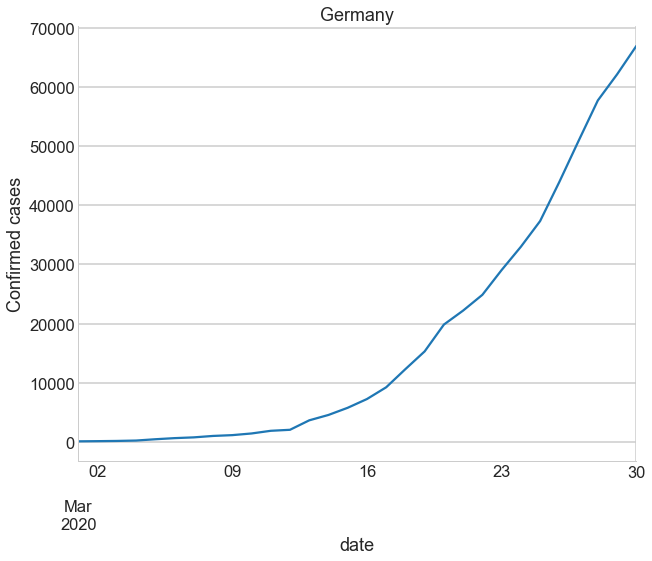

In [3]:
country = 'Germany'
df_country = df.loc[lambda x: (x.country == country)].iloc[:30]

fig, ax = plt.subplots(figsize=(10, 8))
df_country.confirmed.plot(ax=ax)
ax.set(ylabel='Confirmed cases', title=country)
sns.despine()

Let's take `model_exp2` and make it hierarchical for these countries:

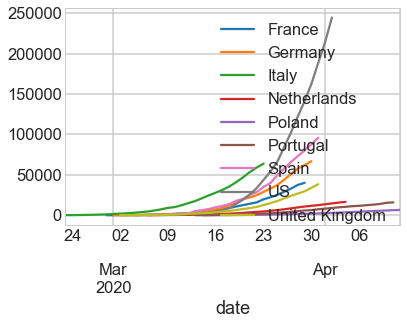

In [79]:
countries = ["Germany", "US", "United Kingdom", "France", "Poland",
             "Italy", "Portugal", "Netherlands", "Spain"]
n_countries = len(countries)
df_countries = df.loc[df.country.isin(countries)].loc[lambda x: x.days_since_100 < 30]
df_countries.groupby("country").confirmed.plot(legend=True);

Here is a basic implementation:

In [119]:
with pm.Model() as model_hierarchical:
    ############
    # Intercept
    # Group mean
    a_grp = pm.Normal('a_grp', 120, 50)
    # Group sd
    a_grp_sigma = pm.HalfNormal('a_grp_sigma', 50)
    # Individual intercepts
    a_ind = pm.Normal('a_ind', 
                      mu=a_grp, sigma=a_grp_sigma, 
                      shape=n_countries)
    ########
    # Slope
    # Group mean
    b_grp = pm.Normal('b_grp', mu=0.1, sigma=1)
    # Group sd
    b_grp_sigma = pm.HalfNormal('b_grp_sigma', .1)
    # Individual slopes
    b_ind = pm.Normal('b_ind', 
                      mu=b_grp, sigma=b_grp_sigma, 
                      shape=n_countries)
    
    alpha = pm.Gamma("alpha", mu=6, sigma=1)
    
    # Create likelihood for each country
    for i, country_name in enumerate(countries):
        df_country = df_countries.loc[lambda x: (x.country == country)]
        
        growth = a_ind[i] * (1 + b_ind[i]) ** df_country.days_since_100.values

        # Due to the exponential, growth can easily take on values
        # too large for our likelihood which causes problems
        # during prior predictive sampling, so we put a maximum on here
        growth = at.clip(growth, 0, 10_000_000)
        
        # Likelihood
        pm.NegativeBinomial(
            country_name,
            growth,
            alpha=alpha,
            observed=df_country.confirmed.values)

### Prior predictive check

Run a prior predictive check and plot the results together with the data. Is this a good model? Can you improve it?

In [ ]:
# Write your answer here

### Sample from the posterior and assess convergence

Perform sampling and see if there are any problems.

What have you learned about hierarchical models that might help with any potential problems? Change the model to be non-centered. This blog post might help: https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/

In [ ]:
# Write your answer here

### Run posterior predictive check

Run a posterior predictive check and plot the results together with the data. Is this a good model?

In [ ]:
# Write your answer here

### Model comparison

Build a fully pooled model and assess convergence.

In [ ]:
# Write your answer here

### Run a posterior predictive check and plot the results

In [ ]:
# Write your answer here

### Define a summary statistic on the posterior predictive and compare the models based on that

Which model seems to do better based on your own defined summary statistic? Does the result surprise you? Think of why that could be the case. Hint: Look at the trace of sigma_grp.

In [ ]:
# Write your answer here